In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle competitions download -c histopathologic-cancer-detection


100% 6.29G/6.31G [00:37<00:00, 240MB/s]
100% 6.31G/6.31G [00:37<00:00, 179MB/s]


In [ ]:
!unzip histopathologic-cancer-detection.zip -d sample_data


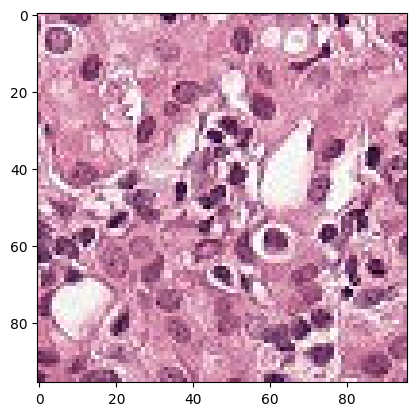

In [6]:
from PIL import Image

# Open the .tif file using PIL
img = Image.open('/content/sample_data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

# Convert the image to a numpy array
img_array = np.array(img)

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(img_array)
plt.show()


In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.decomposition import PCA

# Set path to the directory containing the images
data_dir = '/content/sample_data/train'

# Define a function to load the images and convert them into a 2D array
def load_images(file_list):
    images = []
    for filename in file_list:
        with Image.open(os.path.join(data_dir, filename)) as img:
            img_arr = np.array(img.convert('L'))
            img_arr_flat = img_arr.flatten()
            images.append(img_arr_flat)
    return np.array(images)

# Load a subset of the images
file_list = os.listdir(data_dir)[:1000]
X = load_images(file_list)

# Perform PCA on the image data
pca = PCA(n_components=256)
X_pca = pca.fit_transform(X)

# Print the explained variance ratio for each component
print(pca.explained_variance_ratio_)


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


train_path = "/content/sample_data/train"
label_file = "/content/sample_data/train_labels.csv"

df = pd.read_csv(label_file)

X = []
y = []


for filename in os.listdir(train_path):
    if filename.endswith(".tif"):
        img = Image.open(os.path.join(train_path, filename)).resize((256, 256))
        img_array = np.array(img).flatten()
        X.append(img_array)
        image_id = filename.split(".")[0]
        label = df.loc[df.id == image_id].label.values[0]
        y.append(label)

X = np.array(X)
y = np.array(y)

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)
print("Explained variance ratio:", lda.explained_variance_ratio_[0])


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Define a generator function to load and preprocess the images in batches
def image_batch_generator(image_dir, labels_df, batch_size, image_size):
    while True:
        # Shuffle the image ids
        image_ids = labels_df.sample(frac=1)['id'].tolist()
        # Loop through the image ids in batches
        for i in range(0, len(image_ids), batch_size):
            batch_ids = image_ids[i:i+batch_size]
            # Initialize empty arrays to hold the images and labels for this batch
            X = []
            y = []
            # Loop through the image ids in this batch
            for image_id in batch_ids:
                # Load and preprocess the image
                img = Image.open(os.path.join(image_dir, f"{image_id}.tif")).resize(image_size)
                img_array = np.array(img).flatten()
                X.append(img_array)
                y.append(labels_df.loc[labels_df['id'] == image_id]['label'].values[0])
            # Convert the X and y arrays to numpy arrays
            X = np.array(X)
            y = np.array(y)
            yield (X, y)

# Set the path to the "train" folder and "train_labels.csv" file
train_path = "/path/to/train/folder"
train_labels_path = "/path/to/train_labels.csv"

# Load the train labels file
train_labels = pd.read_csv(train_labels_path)

# Sample 30,000 image ids from the train labels file
sampled_image_ids = train_labels.sample(n=30000, random_state=42)['id'].tolist()

# Initialize the batch size and image size
batch_size = 32
image_size = (256, 256)

# Initialize the image batch generators for the train and validation sets
train_generator = image_batch_generator(train_path, train_labels, batch_size, image_size)
validation_generator = image_batch_generator(validation_path, validation_labels, batch_size, image_size)

# Initialize LDA
lda = LDA(n_components=1)

# Fit LDA on the train set
X_train, y_train = next(train_generator)
X_lda_train = lda.fit_transform(X_train, y_train)

# Print the explained variance ratio of the LDA on the train set
print("Explained variance ratio (train):", lda.explained_variance_ratio_[0])

# Transform the validation set using the trained LDA
X_val, y_val = next(validation_generator)
X_lda_val = lda.transform(X_val)

# Print the explained variance ratio of the LDA on the validation set
print("Explained variance ratio (validation):", lda.explained_variance_ratio_[0])
